In [17]:
#Importaciones Necesarias
#setx CURL_SSL_NO_REVOKE 1
#setx CURL_SSL_NO_REVOKE ""

from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astropy.coordinates import Angle
import astropy.units as u
import pandas as pd
import os
import shutil
import subprocess
from IPython.display import clear_output
import csv
from datetime import datetime
from astropy.time import Time
import matplotlib.pyplot as plt

In [63]:
#Se define la función que obtiene la info de Simbad
Gaia.ROW_LIMIT = -1 
def get_coordinates_from_name(name):
    simbad = Simbad()
    result = simbad.query_object(name)
    if result is not None:
        ra = result['ra'][0] 
        dec = result['dec'][0]
        ra_hms = Angle(ra, unit=u.deg).to_string(unit=u.hourangle, sep=':', precision=7)
        dec_dms = Angle(dec, unit=u.deg).to_string(unit=u.deg, sep=':', precision=6, alwayssign=True)
        
        return ra, dec,ra_hms,dec_dms
    else:
        raise ValueError(f"No se encontraron coordenadas para el objeto {name}")
        
#Se define la función que toma las coordenadas y hace el query en gaia
def query_gaia(ra, dec, radius_arcmin=1):
    radius_deg = radius_arcmin / 60.0  # Conversión: 1 arcmin = 1/60 grados
    try:
        # Realizar la consulta en Gaia
        job = Gaia.launch_job_async(f"""
            SELECT  ra, dec,source_id
            FROM gaiadr2.gaia_source
            WHERE CONTAINS(POINT('ICRS', ra, dec), 
                           CIRCLE('ICRS', {ra}, {dec}, {radius_deg})) = 1
        """)
        results = job.get_results()
        return results
    except Exception as e:
        print("Error en la consulta:", e)
        return None

#Se define la función que guarda los archivos en el csv como catálogo
def save_to_csv():
    ra, dec,ra_hms,dec_dms= get_coordinates_from_name(object_name)
    print(f"Coordenadas de {object_name} - RA: {ra}°, DEC: {dec}°")
    print(f"Coordenadas de {object_name} - RA_HMS: {ra_hms}, DEC_DMS: {dec_dms}")
    
    results = query_gaia(ra, dec, radius_arcmin=radius_arcmin)
    
    print(f"Se hallaron {len(results)} objetos")
    
    data = results.to_pandas()
    data.to_csv('datos_gaia3edr.csv',index = False, header=False,sep=" ")
    rows, columns = data.shape
    

In [65]:
#Obtención del Catálogo
object_name = input("Ingresa el nombre del objeto: ")
radius_arcmin = float(input("Ingresa el radio de búsqueda en arcominutos: "))
save_to_csv()


Ingresa el nombre del objeto:  lambda tau
Ingresa el radio de búsqueda en arcominutos:  10


Coordenadas de lambda tau - RA: 60.1700698910475°, DEC: 12.49034444100722°
Coordenadas de lambda tau - RA_HMS: 4:00:40.8167739, DEC_DMS: +12:29:25.239988
INFO: Query finished. [astroquery.utils.tap.core]
Se hallaron 497 objetos


In [7]:
#Comprobación del directorio de Trabajo, de fallar regersar a la carpeta principal
dest_dir ="./imagenes"
current_dir = os.getcwd()
current_folder = os.path.basename(current_dir)
if f'./{current_folder}' == dest_dir:
    print(f"Estás dentro de {current_folder}. Saliendo...")
    os.chdir("..") 
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
    
#Definir la función que descarga las imagenes del archivo .sh
def ejecutar_curl_desde_archivo(archivo_sh, linea_inicio, linea_final):
    with open(archivo_sh, "r") as archivo:
        for i, linea in enumerate(archivo):
            if i < linea_inicio:
                continue
            if i > linea_final:
                break

            linea = linea.strip()

            print(f"Descargando imagen {i} de {linea_final}")
            print(f"Ejecutando: {linea}")
            os.chdir(dest_dir)
            try:
                result = subprocess.run(linea, shell=True, text=True)
            except Exception as e:
                print(f"Error al ejecutar la línea {linea}: {e}")
            
            os.chdir("..")
            clear_output(wait=True)
            

In [9]:
#Se define la función principal, esta descarga imágenes y las analiza con phot3.py
def Descarga_y_analizis(inicio,fin):
    dest_dir ="./imagenes"
    current_dir = os.getcwd()
    current_folder = os.path.basename(current_dir)
    if f'./{current_folder}' == dest_dir:
        print(f"Estás dentro de {current_folder}. Saliendo...")
        os.chdir("..") 

    ejecutar_curl_desde_archivo("tesscurl_sector_18_ffic.sh",inicio, fin)
    with open("tesscurl_sector_18_ffic.sh", "rb") as archivo:  # Modo binario para mayor velocidad
        print(f"Es posible descargar {sum(1 for _ in archivo)} imágenes del sector")
    print(f"Descarga de las imagenes {inicio} a la {fin} Finalizada")
    print("Analizando las imagenes...")
    
    result = subprocess.run("python phot3.py", shell=True, capture_output=True, text=True)
    print(result.stdout)
    print(result.stderr)
    
    shutil.rmtree("./imagenes")
    os.makedirs("./imagenes", exist_ok=True)
    print("\nImagenes borradas de la carpeta imagenes, proceso finalizado ")

In [11]:
#Recibe dos argumentos; la linea de inicio y de finalización
Descarga_y_analizis(1100,1101)

Es posible descargar 17713 imágenes del sector
Descarga de las imagenes 1100 a la 1103 Finalizada
Analizando las imagenes...

Su carpeta contiene 4 archivos .fits 

No. 1: tess2019317045925-s0018-3-4-0162-s_ffic.fits
          ....            
No. 4: tess2019323162925-s0018-1-1-0162-s_ffic.fits



 
 Se obtuvieron 1 archivos .csv
Archivos .out almacenados en fits_out
Archivos .csv almacenados en csv_out



Imagenes borradas de la carpeta imagenes, proceso finalizado 


In [59]:
#Esto lo que hace es analizar los datos csv, y construir las dos listas con los datos a graficar
nombre_carpeta = "csv_out"
directorio = os.getcwd()
directorio= os.path.basename(directorio)
if not f'{directorio}' == nombre_carpeta:
    os.chdir("./csv_out")
fechas=[]
magnitudes=[]
#Proceso de iteración
for archivo in os.listdir("./"):
        with open(archivo, mode='r', newline='', encoding='utf-8') as archivo_csv:
            lector = csv.reader(archivo_csv)
            for fila in lector:
                if fila[0] == '239863001382455424': #Definir id de simbad del objeto
                    fechas.append(fila[5])
                    magnitudes.append(float(fila[3]))

print(f"Datos agregados correctamente, actualmente se cuenta con {len(magnitudes)} datos")
os.chdir("..")


Datos agregados correctamente, actualmente se cuenta con 0 datos


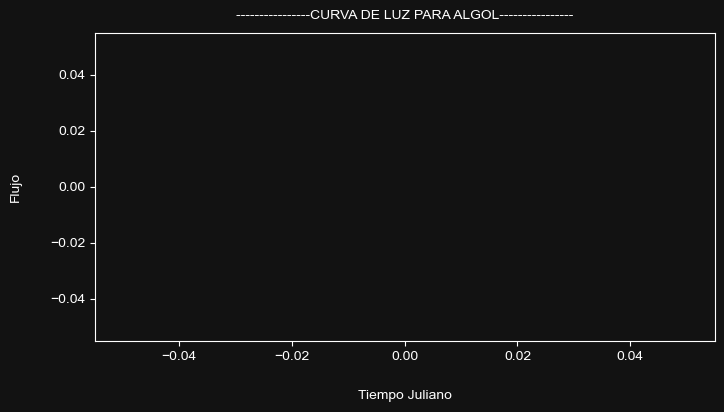

In [61]:
#La gráfica no habria que mover nada aquí
fechas_clean = [Time(f, format='isot', scale='utc').jd for f in fechas]
fechas_clean_2 = [datetime.strptime(f, "%Y-%m-%dT%H:%M:%S.%f") for f in fechas]

flujos=[]
for i in magnitudes:
    flujos.append(10**(-i/2.5))

plt.rcParams.update({
    'axes.facecolor': '#121212',  # Fondo del área del gráfico (gris oscuro)
    'figure.facecolor': '#121212',  # Fondo de la figura (gris oscuro)
    'font.family': 'Arial',  # Fuente
    'font.size': 10 ,  # Tamaño de la fuente
    'axes.labelcolor': 'white',  # Color de las etiquetas de los ejes (blanco)
    'xtick.color': 'white',  # Color de las etiquetas en el eje X (blanco)
    'ytick.color': 'white',  # Color de las etiquetas en el eje Y (blanco)
    'axes.edgecolor': 'white',  # Color de los bordes del gráfico (blanco)
    'grid.color': '#404040',  # Color de la cuadrícula (gris claro)
    'grid.linestyle': '--',  # Estilo de la cuadrícula (líneas discontinuas)
    'grid.alpha': 0.3,  # Transparencia de la cuadrícula (más suave)
    'lines.color': 'cyan',  # Color de las líneas (cian brillante)
    'lines.linewidth': 2,  # Ancho de las líneas
    'axes.titlecolor': 'white',  # Color del título de los ejes (blanco)
})

alto,ancho=4,8
plt.figure(figsize=(ancho, alto))  
plt.plot(fechas_clean[:], flujos[:], marker='o', linestyle='-', color="white",markerfacecolor='none', linewidth=1)
plt.xlabel("Tiempo Juliano",fontsize=10,labelpad=20)
plt.ylabel("Flujo",fontsize=10,labelpad=20) 
plt.title(f"----------------Curva de luz para {object_name}----------------".upper(), fontsize=10,pad=10)

plt.show()


La frecuencia con el valor máximo de potencia es: 2.536503630166697
El valor máximo de potencia es: 6.300538198896425e-06


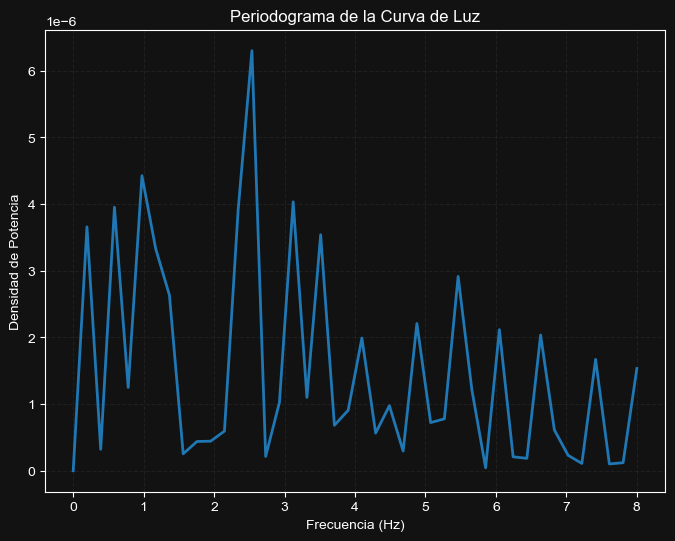

In [57]:
from scipy.signal import periodogram
import numpy as np
frequencies, power = periodogram(flujos, fs=1/(fechas_clean[1] - fechas_clean[0]), scaling='density')

indice_max = np.argmax(power)

# Obtener la frecuencia correspondiente al valor máximo de power
frecuencia_max = frequencies[indice_max]

# Mostrar la frecuencia y su valor máximo de potencia
print("La frecuencia con el valor máximo de potencia es:", frecuencia_max)
print("El valor máximo de potencia es:", power[indice_max])

# Graficar el periodograma
plt.figure(figsize=(8, 6))
plt.plot(frequencies, power)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad de Potencia')
plt.title('Periodograma de la Curva de Luz')
plt.grid(True)
plt.show()